In [1]:
import pandas as pd
import seaborn as sns
import pickle

from tqdm import tqdm
from os.path import exists
from cleantext import cleantext
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danielalexander.muro\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
# Paths and variables

csv_path = 'data/dataset/imdb_dataset.csv'
plk_path = 'data/cleaned_reviews.plk'
model_path = 'data/model.sav'
tv_path = 'data/tv.sav'

In [29]:
reviews_df = pd.read_csv(csv_path)
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [30]:
reviews_df['sentiment'] = [1 if sentiment == 'positive' else 0 for sentiment in reviews_df['sentiment']] #Replace positive and negative values by 1 and 0 respectively
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


C:\Users\danielalexander.muro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

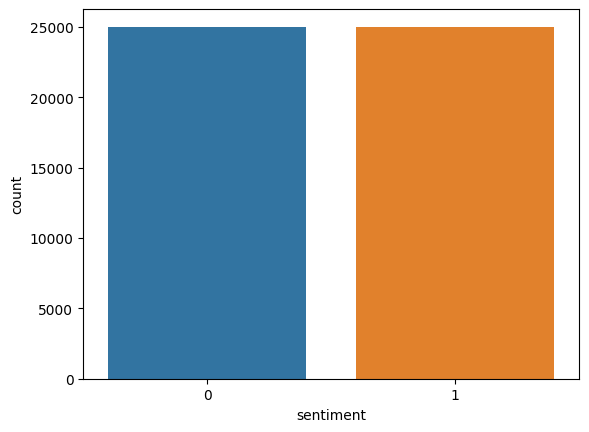

In [32]:
sns.countplot(reviews_df['sentiment'])

In [34]:
cleaned_reviews = []

# Check if my list of reviews was already cleaned and saved as plk. If so, then open it
if exists(plk_path):
    print('Getting cleaned reviews from file')
    cleaned_reviews = pd.read_pickle(plk_path)
# Otherwise, clean the data from the csv file and ave it into a plk file
else:
    print('Cleaning data from reviews dataset')
    for i in tqdm(range(0,len(reviews_df))):
        sentence = reviews_df['review'][i] #get one sentence
        sentence = cleantext(sentence) #clean it
        cleaned_reviews.append(sentence) #add it to the list
    print('Saving cleaned reviews into file')
    cleaned_reviews.to_pickle(plk_path)
    print('Rewiews saved successfully in %s' % plk_path)

Getting cleaned reviews from file


In [163]:
"""
unique = set([])
for review in cleaned_reviews:
    split = review.split()
    for word in split:
        unique.add(word)

print('There are %s different words along all the reviews.' %len(unique))
"""

There are 70962 different words along all the reviews.


In [35]:
# Count frequency of words along all the reviews and
# create a dictionary with all the words and its frequency
counts = dict()
for review in cleaned_reviews:
    words = review.split()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

In [36]:
# A word will be considered as relevant
# only if it appears at least 50 times along all the 50K reviews
frequent_words = {word:freq for word,freq in counts.items() if freq >= 50}

# features will be the quantity of words which will be considered
features = len(frequent_words)

# TF-IDF

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

[Differences](https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/)

In [37]:
# Create tf-idf vectorisation with the text of the reviews already cleaned
tv = TfidfVectorizer(max_features=features) # Create a feature matrix out of the most frequents words (those appearing at least 50 times each)
X = tv.fit_transform(cleaned_reviews).toarray()

In [38]:
X.shape

(50000, 8389)

In [39]:
# y = sentiment (1 = positive and 0 = negative)
y = reviews_df['sentiment'].to_numpy()

In [40]:
y.shape

(50000,)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# X_train => array of 40000 rows of 8389 0's or 1's showing the presence of each word in each review
# y_train => array of 40000 rows of 8389 0's or 1's indicating the sentiment of each review
# X_test  => array of 10000 rows of 8389 0's or 1's showing the presence of each word in each review
# y_test  => array of 10000 rows of 8389 0's or 1's indicating the sentiment of each review

In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 8389)
(40000,)
(10000, 8389)
(10000,)


The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [43]:
model = MultinomialNB().fit(X_train, y_train)

In [44]:
y_pred = model.predict(X_test)

In [45]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_pred,y_test))

0.8506
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      5005
           1       0.85      0.85      0.85      4995

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [65]:

# Save the model to file
pickle.dump(model, open(model_path, 'wb'))
# Save the tokenizer
pickle.dump(tv, open(tv_path, 'wb'))

Making a New Prediction

In [47]:
new_review = 'I Hate this movie so much. It\'s ok.'
#new_review = 'This is the best movie I\'ve ever seen'
new_corpus = [cleantext(new_review)]

In [48]:
new_X_test = tv.transform(new_corpus).toarray()
new_y_pred = model.predict(new_X_test)
print('Positive' if new_y_pred == 1 else 'Negative')

Negative
